In [1]:
!pip install git+https://github.com/desi-bgs/bgs-cmxsv.git --upgrade --user

  Cloning https://github.com/desi-bgs/bgs-cmxsv.git to /tmp/pip-req-build-9dv99l0y
  Running command git clone -q https://github.com/desi-bgs/bgs-cmxsv.git /tmp/pip-req-build-9dv99l0y
  Created wheel for bgs-sv: filename=bgs_sv-0.0-py3-none-any.whl size=1057610 sha256=22651c316ad9e77eb663f82aee0d6c692ed513c32cb548737090dd580af69482
  Stored in directory: /tmp/pip-ephem-wheel-cache-0_uudik3/wheels/c5/7b/33/3fa8f7338087a37e7ad7a1378e08d97458e5dbab577a10268f
Successfully built bgs-sv
  Attempting uninstall: bgs-sv
    Found existing installation: bgs-sv 0.0
    Uninstalling bgs-sv-0.0:
      Successfully uninstalled bgs-sv-0.0


In [2]:
import numpy as np 
import astropy.table as atable
import matplotlib.pyplot as plt

from bgs_sv import sv1

# read nightly combined exposures from Blanc reduction
As of Jan 15, 2021 we don't have redrock outputs for single exposures --- only for nightly combined exposures

In [3]:
nightly_exp = sv1.blanc_nightly_exposures()

In [4]:
# lets only keep the nightly exposures where we have a corresponding 
# deep exposure that we can use as the truth table
deep_exp = sv1.blanc_deep_exposures()

keep = np.zeros(len(nightly_exp)).astype(bool)
for i in range(len(nightly_exp)): 
    if nightly_exp[i]['TILEID'] in deep_exp['TILEID']: 
        keep[i] = True
print('%i nightly exposures with corresponding deep exposures' % np.sum(keep))

57 nightly exposures with corresponding deep exposures


In [5]:
nightly_exp[keep]

TILEID,NIGHT,EXPTIME,B_DEPTH,R_DEPTH,Z_DEPTH,TILERA,TILEDEC
int64,int64,float32,float32,float32,float32,float32,float32
80605,20201215,1800.119,827.8,661.7,599.8,36.448,-4.601
80605,20201216,2700.069,3479.0,2726.5,2281.8,36.448,-4.601
80606,20201215,3600.314,1930.7,1474.0999,1285.0,36.448,-4.501
80606,20201216,3600.1392,6168.4,4780.8,4122.4004,36.448,-4.501
80606,20201218,900.077,883.3,905.5,1101.3,36.448,-4.501
80606,20201219,1800.138,579.69995,959.2,1552.0,36.448,-4.501
80607,20201214,2700.2358,1366.7,1191.6001,1242.6001,106.74,56.1
80607,20201215,1800.1741,1175.9,1000.69995,975.89996,106.74,56.1
80607,20201218,3600.094,6122.1,5340.7,5293.5996,106.74,56.1


# read redrock output for nightly combined exposures

In [6]:
zbest_deep = sv1.get_zbest(nightly_exp['TILEID'][0], 'deep')
zbest_night = sv1.get_zbest(nightly_exp['TILEID'][0], nightly_exp['NIGHT'][0])

In [7]:
zbest_deep[:5]

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,TARGET_RA,TARGET_DEC,FLUX_R,FIBERFLUX_R,PHOTSYS,SV1_DESI_TARGET,SV1_BGS_TARGET,DESI_TARGET,BGS_TARGET
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32,float64,float64,float32,float32,str1,int64,int64,int64,int64
39627634551824898,12765.848863855004,413.7452264686265 .. 7.6750538522796665,0.35498046306149317,4.242312139165223e-05,0,7930,GALAXY,,10,2334.764277115464,0,1,36.18946453136912,-6.149115843122294,21.593157,5.7867155,S,1152921504715898985,131074,0,0
39627634564402484,11917.65437489003,142.71816839037803 .. 9.795721375403408,0.4326407604793134,6.273214088826393e-05,0,7922,GALAXY,,10,621.1682955697179,0,1,36.81021305541879,-6.128079808810531,10.5774355,2.2589812,S,1152921504732676217,65537,0,0
39627640562254190,14053.865803301334,384.9149339485621 .. 6.973597673152174,0.31898570258425285,2.0462082886460148e-05,0,7918,GALAXY,,10,2657.9614642784,0,1,36.160836912292886,-6.1040144546594,32.21851,6.3116837,S,1152921504673955905,131074,0,0
39627640562256563,12700.472152590752,103.29207301053151 .. 10.743015578045881,0.19543781189160145,6.7779049917149135e-06,0,7929,GALAXY,,10,3011.720482945442,0,1,36.23947160565423,-6.021425106054532,17.301945,3.4992018,S,1152921504673955905,131074,0,0
39627640562256594,12995.6548923105,251.00667106363053 .. 1.3817486739900724,0.4926269489392618,6.181581366291226e-05,0,7929,GALAXY,,10,1038.019756808877,0,1,36.240498453979356,-5.88647942450762,7.5087867,3.068208,S,1152921504707510369,262148,0,0


In [8]:
zbest_night[:5]

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,TARGET_RA,TARGET_DEC,FLUX_R,FIBERFLUX_R,PHOTSYS,SV1_DESI_TARGET,SV1_BGS_TARGET,DESI_TARGET,BGS_TARGET
int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32,float64,float64,float32,float32,str1,int64,int64,int64,int64
39627634551824898,12848.546187251806,394.4522121088542 .. 5.507938642526083,0.35501722484261133,6.155077164203288e-05,0,7930,GALAXY,,10,1153.790137693286,0,1,36.18946453136912,-6.149115843122294,21.593157,5.7867155,S,1152921504715898985,131074,0,0
39627634564402484,12168.07149542123,82.98112202194685 .. 4.047172386564999,0.4323560118417947,6.83645473919245e-05,0,7924,GALAXY,,10,307.4811639711261,0,1,36.81021305541879,-6.128079808810531,10.5774355,2.2589812,S,1152921504732676217,65537,0,0
39627640562254190,13602.403392761946,461.02700595429496 .. 12.32818278029257,0.31898821762073165,2.266787478637561e-05,0,7922,GALAXY,,10,1695.3971286602318,0,1,36.160836912292886,-6.1040144546594,32.21851,6.3116837,S,1152921504673955905,131074,0,0
39627640562256563,12610.318417072296,281.31699538870265 .. 23.760522880197623,0.1954481753695959,7.742104957569853e-06,0,7927,GALAXY,,10,2257.378125190735,0,1,36.23947160565423,-6.021425106054532,17.301945,3.4992018,S,1152921504673955905,131074,0,0
39627640562256594,12962.099266499281,323.941431536021 .. 4.429296043320544,0.49265211226740774,4.516829279277378e-05,0,7929,GALAXY,,10,671.4332208931446,0,1,36.240498453979356,-5.88647942450762,7.5087867,3.068208,S,1152921504707510369,262148,0,0


# caclulate $z$ success rate using the deep exposures as the truth table

In [9]:
def zsuccess_redrock_criteria(zbest): 
    ''' redshift success criteria based only on redrock output
    '''
    crit_zwarn = (zbest['ZWARN'] == 0)
    crit_dchi2 = (zbest['DELTACHI2']  > 40.) 
    crit_stype = (zbest['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zbest['Z'] > 0.0) & (zbest['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zbest['ZERR'] < (0.0005 * (1. + zbest['Z'])))

    # combine all criteria
    zsuccess = crit_zwarn & crit_dchi2 & crit_stype & crit_z_lim & crit_z_err
    return zsuccess

def zsuccess_truth_criteria(zbest, z_true, silent=True): 
    ''' redshift success criteria based on redrock output *and* comparison
    to "true" redshift
    '''
    crit_zwarn = (zbest['ZWARN'] == 0)
    crit_dchi2 = (zbest['DELTACHI2']  > 40.) 
    crit_stype = (zbest['SPECTYPE'] != "STAR") # only galaxy spectra
    crit_z_lim = (zbest['Z'] > 0.0) & (zbest['Z'] < 0.6) # rough BGS redshift limit
    crit_z_err = (zbest['ZERR'] < (0.0005 * (1. + zbest['Z'])))
    
    dz_1pz = np.abs(z_true - zbest['Z']) / (1. + z_true)
    crit_ztrue = (dz_1pz < 0.003)

    # combine all criteria
    zsuccess = crit_zwarn & crit_dchi2 & crit_stype & crit_z_lim & crit_z_err & crit_ztrue
    if not silent: 
        print('%i of %i pass the redshift success criteria' % (np.sum(zsuccess), len(zsuccess)))
        print('%.2f redshift success rate' % (np.sum(zsuccess)/len(zsuccess)))
    return zsuccess

In [10]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`

    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 

    :params zsuccess_cond:
        boolean array indicating redshift success 

    :params range: (default: None) 
        range of the `prop` 

    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 

    :return wmean: 
        weighted mean of `prop` in the bins 

    :return e1: 
        redshift success rate in the bins

    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate

In [11]:
# only use targets where we have accurate redshifts in the deep exposure
_zbest_deep = sv1.get_zbest(nightly_exp['TILEID'][0], 'deep')
zs_deep = zsuccess_redrock_criteria(_zbest_deep)

zbest_deep = _zbest_deep[zs_deep]['TARGETID', 'Z']
zbest_deep.rename_column('Z', 'Z_TRUE') # deep exposure redshift is the "true redshift"

In [12]:
_zbest_night = sv1.get_zbest(nightly_exp['TILEID'][0], nightly_exp['NIGHT'][0])
zbest_night = atable.join(zbest_deep, _zbest_night, keys='TARGETID', join_type='left')

In [13]:
# calculate redshift successs rate
zs_night = zsuccess_truth_criteria(zbest_night, zbest_night['Z_TRUE'])

Text(0, 0.5, '$z$ success rate')

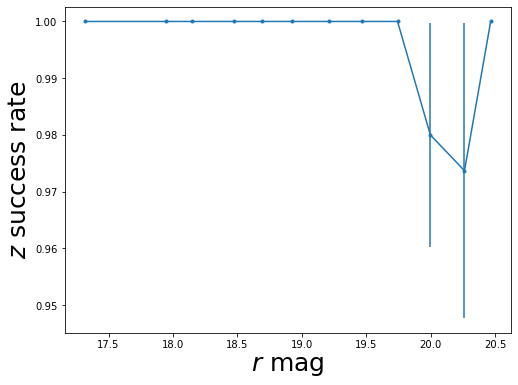

In [14]:
r_mag = 22.5 - 2.5 * np.log10(zbest_night['FLUX_R'])
r_mid, zs, zs_err = zsuccess_rate(r_mag, zs_night)

fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C0')
sub.plot(r_mid, zs)
sub.set_xlabel('$r$ mag', fontsize=25)
sub.set_ylabel('$z$ success rate', fontsize=25)

# Lets look at the redshift success for the nightly exposures for all tiles with deep exposure

 /global/cfs/cdirs/desi/spectro/redux/blanc/tiles/80607/20201222/zbest-3-80607-20201222.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux/blanc/tiles/80617/20201218/zbest-3-80617-20201218.fits does not exist
 /global/cfs/cdirs/desi/spectro/redux/blanc/tiles/80619/20201219/zbest-3-80619-20201219.fits does not exist


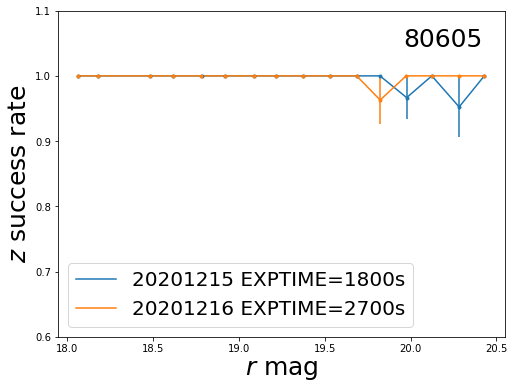

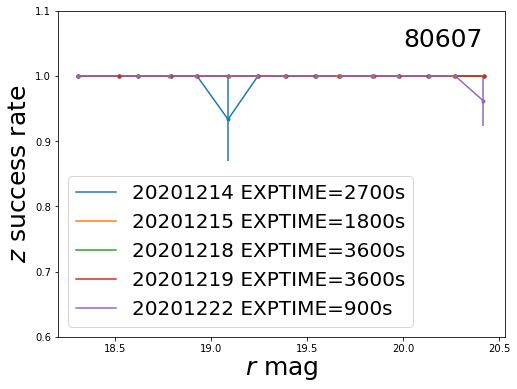

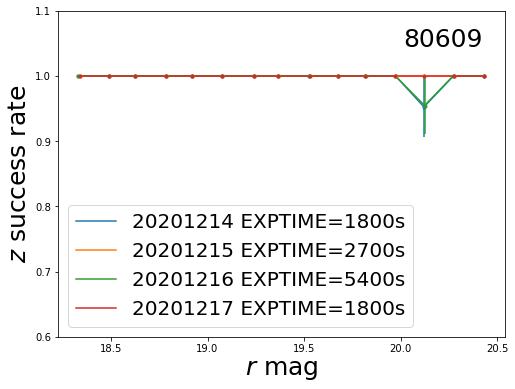

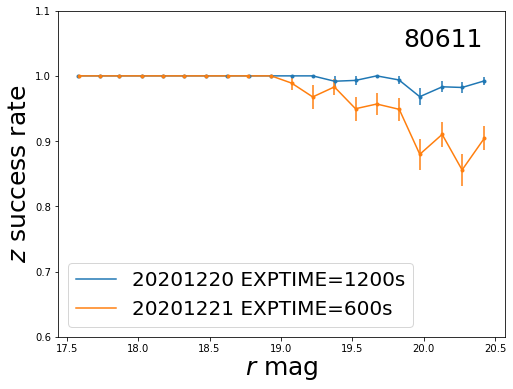

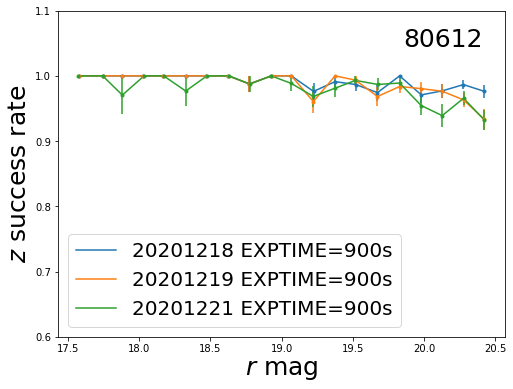

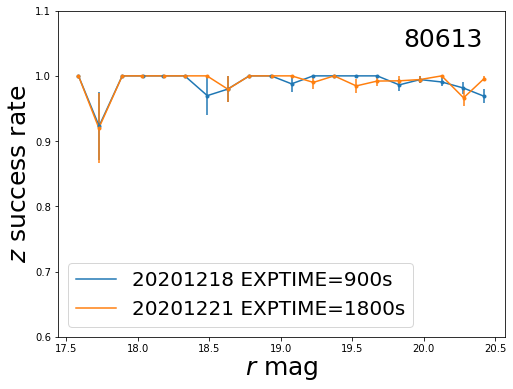

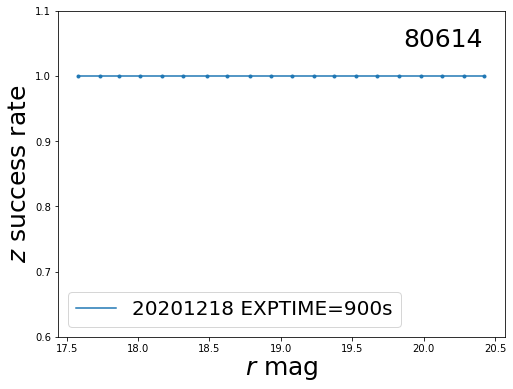

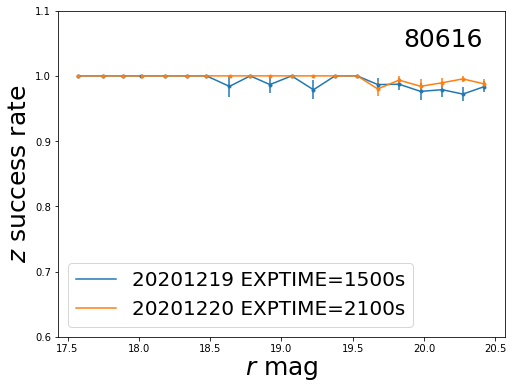

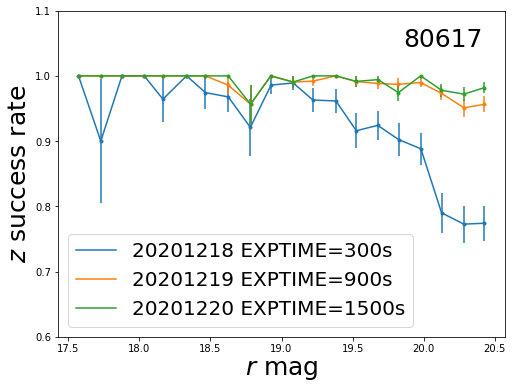

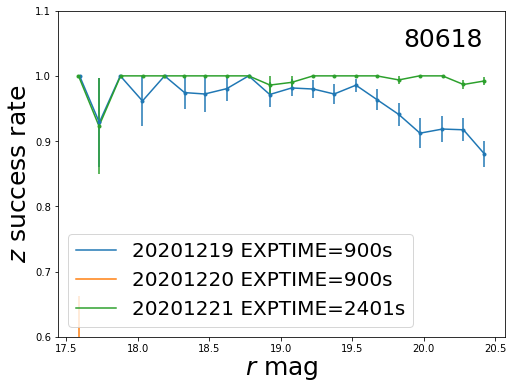

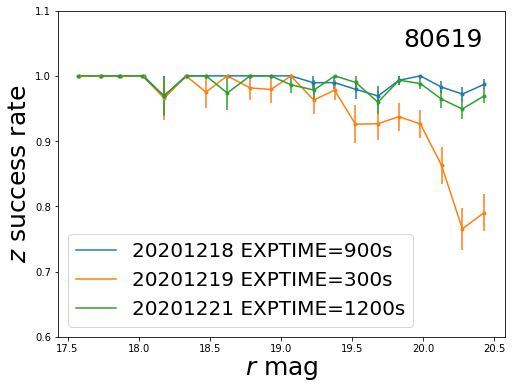

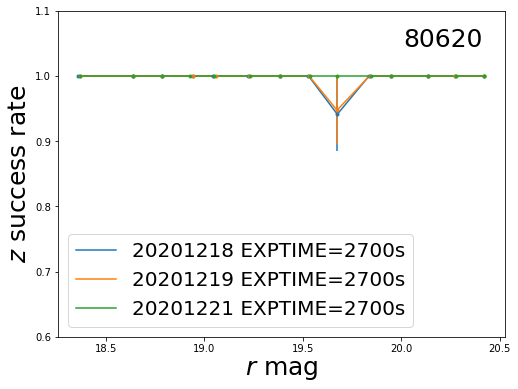

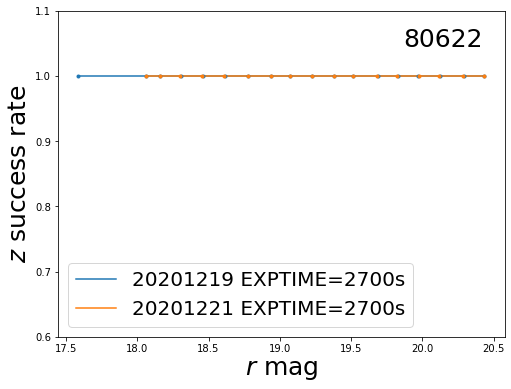

In [15]:
for tileid in deep_exp['TILEID']: 
    # only use targets where we have accurate redshifts in the deep exposure
    try: 
        _zbest_deep = sv1.get_zbest(tileid, 'deep')
    except:
        continue 
    zs_deep = zsuccess_redrock_criteria(_zbest_deep)
    
    zbest_deep = _zbest_deep[zs_deep]['TARGETID', 'Z']
    zbest_deep.rename_column('Z', 'Z_TRUE') # deep exposure redshift is the "true redshift"
    
    if len(zbest_deep) < 100: continue
    
    fig = plt.figure(figsize=(8,6))
    sub = fig.add_subplot(111)
    
    corresp_nights = np.where(nightly_exp['TILEID'] == tileid)[0]
    for ii, i in enumerate(corresp_nights): 
        _zbest_night = sv1.get_zbest(nightly_exp['TILEID'][i], nightly_exp['NIGHT'][i])
        zbest_night = atable.join(zbest_deep, _zbest_night, keys='TARGETID', join_type='inner')

        # calculate redshift successs rate
        zs_night = zsuccess_truth_criteria(zbest_night, zbest_night['Z_TRUE'])

        r_mag = 22.5 - 2.5 * np.log10(zbest_night['FLUX_R'])
        r_mid, zs, zs_err = zsuccess_rate(r_mag, zs_night, range=[17.5, 20.5])

        sub.errorbar(r_mid, zs, yerr=zs_err, fmt='.C%i' % ii)
        sub.plot(r_mid, zs, c='C%i' % ii, label='%s EXPTIME=%.fs' % (str(nightly_exp['NIGHT'][i]), nightly_exp['EXPTIME'][i]))
    sub.legend(loc='lower left', fontsize=20)
    sub.text(0.95, 0.95, str(tileid), transform=sub.transAxes, ha='right', va='top', fontsize=25) 
    sub.set_xlabel('$r$ mag', fontsize=25)
    sub.set_ylabel('$z$ success rate', fontsize=25)
    sub.set_ylim(0.6, 1.1)